First baseline in Kaggle Inclass [competition](https://www.kaggle.com/c/how-good-is-your-medium-article) "How good is your Medium article?"

Import libraries.

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import json
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error

The following code will help to throw away all HTML tags from an article content.

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Let's have two paths – to raw data (downloaded from competition's page and ungzipped) and to processed data. Change this if you'd like to.

In [3]:
PATH_TO_RAW_DATA = '../raw_data/'
PATH_TO_PROCESSED_DATA = '../processed_data/'

Assume you have all data downloaded from competition's [page](https://www.kaggle.com/c/how-good-is-your-medium-article/data) in the PATH_TO_RAW_DATA folder and `.gz` files are ungzipped.

In [4]:
!ls -l $PATH_TO_RAW_DATA

total 6336840
-rw-r--r--  1 y.kashnitsky  staff      508683  5 мар 01:32 sample_submission.csv
-rw-r--r--  1 y.kashnitsky  staff  1156020029  5 мар 09:41 test.json
-rw-r--r--  1 y.kashnitsky  staff  2086185062  5 мар 09:41 train.json
-rw-r--r--  1 y.kashnitsky  staff      912544  5 мар 01:32 train_log1p_recommends.csv


This function takes a JSON and forms a txt file leaving only article content. When you resort to feature engineering and extract various features from articles, a good idea is to modify this function.

In [5]:
def preprocess(path_to_inp_json_file, path_to_out_txt_file):
    with open(path_to_inp_json_file) as inp_file, \
        open(path_to_out_txt_file, 'w') as out_file:
        for line in tqdm_notebook(inp_file):
            json_data = json.loads(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            out_file.write(content_no_html_tags + '\n')

In [6]:
%%time
preprocess(path_to_inp_json_file=os.path.join(PATH_TO_RAW_DATA, 'train.json'),
           path_to_out_txt_file=os.path.join(PATH_TO_PROCESSED_DATA, 'train_raw_content.txt'))

Widget Javascript not detected.  It may not be installed or enabled properly.



CPU times: user 4min 49s, sys: 3.66 s, total: 4min 53s
Wall time: 4min 53s


In [7]:
%%time
preprocess(path_to_inp_json_file=os.path.join(PATH_TO_RAW_DATA, 'test.json'),
           path_to_out_txt_file=os.path.join(PATH_TO_PROCESSED_DATA, 'test_raw_content.txt'))

Widget Javascript not detected.  It may not be installed or enabled properly.



CPU times: user 2min 41s, sys: 2.08 s, total: 2min 43s
Wall time: 2min 43s


In [8]:
!wc -l $PATH_TO_PROCESSED_DATA/*_raw_content.txt

   34645 ../processed_data//test_raw_content.txt
   62313 ../processed_data//train_raw_content.txt
   96958 total


We'll use a linear model (`Ridge`) with a very simple feature extractor – `CountVectorizer`, meaning that we resort to the Bag-of-Words approach. For now, we are leaving only 50k features. 

In [9]:
cv = CountVectorizer(max_features=50000)

In [10]:
%%time
with open(os.path.join(PATH_TO_PROCESSED_DATA, 'train_raw_content.txt')) as input_train_file:
    X_train = cv.fit_transform(input_train_file)

CPU times: user 1min 41s, sys: 2.37 s, total: 1min 44s
Wall time: 1min 44s


In [11]:
%%time
with open(os.path.join(PATH_TO_PROCESSED_DATA, 'test_raw_content.txt')) as input_test_file:
    X_test = cv.transform(input_test_file)

CPU times: user 49.3 s, sys: 679 ms, total: 50 s
Wall time: 50 s


In [12]:
X_train.shape, X_test.shape

((62313, 50000), (34645, 50000))

Read targets from file.

In [13]:
train_target = pd.read_csv(os.path.join(PATH_TO_RAW_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')

In [14]:
y_train = train_target['log_recommends'].values

Make a 30%-holdout set. 

In [15]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_train[train_part_size:, :]
y_valid = y_train[train_part_size:]

Now we are ready to fit a linear model.

In [16]:
from sklearn.linear_model import Ridge

In [17]:
ridge = Ridge(random_state=17)

In [18]:
%%time
ridge.fit(X_train_part, y_train_part);

CPU times: user 2min 39s, sys: 835 ms, total: 2min 40s
Wall time: 2min 40s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [19]:
ridge_pred = ridge.predict(X_valid)

Let's plot predictions and targets for the holdout set. Recall that these are #recommendations (= #claps) of Medium articles with the `np.log1p` transformation.

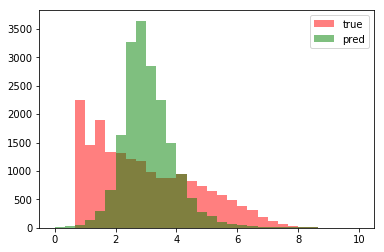

In [20]:
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

As we can see, the prediction is far from perfect, and we get MAE $\approx$ 1.3 that corresponds to $\approx$ 2.7 error in #recommendations.

In [21]:
valid_mae = mean_absolute_error(y_valid, ridge_pred)
valid_mae, np.expm1(valid_mae)

(1.3060947121324362, 2.691728262156526)

Finally, train the model on the full accessible training set, make predictions for the test set and form a submission file. 

In [22]:
%%time
ridge.fit(X_train, y_train);

CPU times: user 3min 51s, sys: 1.62 s, total: 3min 52s
Wall time: 3min 53s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [23]:
%%time
ridge_test_pred = ridge.predict(X_test)

CPU times: user 110 ms, sys: 53.8 ms, total: 164 ms
Wall time: 162 ms


In [24]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_RAW_DATA, 'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [25]:
write_submission_file(prediction=ridge_test_pred, 
                      filename='first_ridge.csv')

With this, you'll get 1.91185 on [public leaderboard](https://www.kaggle.com/c/how-good-is-your-medium-article/leaderboard). This is much higher than our validation MAE. This indicates that the target distribution in test set somewhat differs from that of the training set (recent Medium articles are more popular). This shouldn't confuse as long as we see a correlation between your local improvements and improvements on the leaderboard. 

Some ideas for improvement:
- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used `C`=1 as a regularization parameter, this can be changed 
- SGD and Vowpal Wabbit will learn much faster
- In our course, we don't cover neural nets. But it's not obliged to use GRUs or LSTMs in this competition. 